In [76]:
import re
from collections import Counter
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report,plot_confusion_matrix, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

# Cenário 3 - Outliers

In [77]:
incidentes = pd.read_csv("../input/train_data_cleaned.csv", index_col=0)
teste = pd.read_csv("../input/test_data_cleaned.csv", index_col=0)

* TRATAMENTO SIMPLES

Vamos testar as abordagens que se costumam fazer, detetar outliers e tratá-los.

Método: vamos fazer uma análise simples e univariada, inicialmente. 
É sabido que existem diferentes métodos de detetar outliers, seja Z-SCORE, IQR DISTANCE, Median Absolute Deviation method. 
Cada um é mais ou menos apropriado dependendo do tipo de distribuição que os nossos dados seguirem:
* O Z_SCORE assume uma distribuição normal nos dados, sendo que é super sensível à média e ao desvio padrão;
* MAD vêm tornar o método Z_SCORE mais robusto;
* IQR DISTANCE é mais simples e facilmente extensível para dados com skewness;
Tendo isto em conta, vamos feature a feature, analisar a distribuição dos dados.

Vamos tratar:
* Magnitude do atraso, Luminosidade, Intensidade da Chuva, Velocidade do Vento (0-10): sendo uma espécie de categoria com ordem entre si, não faz sentido tratar;
* Atraso em segundos, Temperatura média, Pressão média, Humidade Média: númerica, vamos **tratar**;
* Tipos de Estradas: discreto, ordinal, frequência de incidentes em estradas nacionais ou regionais, não trataremos.

Vamos utilizar o seguinte método:
* Para dados que seguem uma distribuição normal, seguiremos o método MAD, já que é mais robusto;
* Para dados que não seguem uma distribuição normal, utilizaremos o método IQR DISTANCE.

Quando temos um conjunto de dados com valores discrepantes que distorcem os dados, a mediana será uma medida melhor de tendência central do que a média, e o intervalo interquartil será uma medida melhor de dispersão do que o desvio padrão. Isso porque a média e o desvio padrão levarão em consideração todos os pontos do conjunto de dados, incluindo os valores discrepantes. Mas a mediana e o IQR podem ignorar esses valores discrepantes, fornecendo medições mais precisas dos dados.

In [78]:
# dados, lista de colunas, flg com método de deteção, method = string com a forma de os substituir.
def process_outliers(df, columns, flag, method):
    if flag == 1:
        # Use IQR distance to detect outliers
        for col in columns:
            median = df[col].median()
            lower_quartile = df[col].quantile(0.25)
            upper_quartile = df[col].quantile(0.75)
            iqr = upper_quartile - lower_quartile

            # Find the rows with outliers
            outliers = df[(df[col] < lower_quartile - 1.5 * iqr) | (df[col] > upper_quartile + 1.5 * iqr)]
            indices = outliers.index
            #outliers_per = len(outliers)/len(df[col] * 100)

            # Process the outliers according to the specified method
            if method == "remove":
                df = df.drop(indices)
            elif method == "median":
                df.loc[indices, col] = median
            elif method == "mode":
                df.loc[indices, col] = df[col].mode()[0]
            elif method == "mean":
                df.loc[indices, col] = df[col].mean()
    elif flag == 2:
        # Use MAD to detect outliers
        for col in columns:
            median = df[col].median()
            mad = np.mean(np.abs(df[col] - median))

            # Find the rows with outliers
            outliers = df[(df[col] - median).abs() > 3*mad]
            indices = outliers.index

            # Process the outliers according to the specified method
            if method == "remove":
                df = df.drop(indices)
            elif method == "median":
                df.loc[indices, col] = median
            elif method == "mode":
                df.loc[indices, col] = df[col].mode()[0]
            elif method == "mean":
                df.loc[indices, col] = df[col].mean()
    else:
        raise ValueError("Invalid flag. Must be 1 (IQR) or 2 (MAD).")

    return df

In [79]:
# recebe o dataset e uma lista de colunas e imprime box-plot de cada uma numa figura
def plot_boxplots(df, columns):
    fig, ax = plt.subplots(1, len(columns), figsize=(12, 4))
    
    for i, col in enumerate(columns):
        ax[i].boxplot(df[col])
        ax[i].set_title(col)
    
    plt.show()

### Método 1 - Substituir pela moda

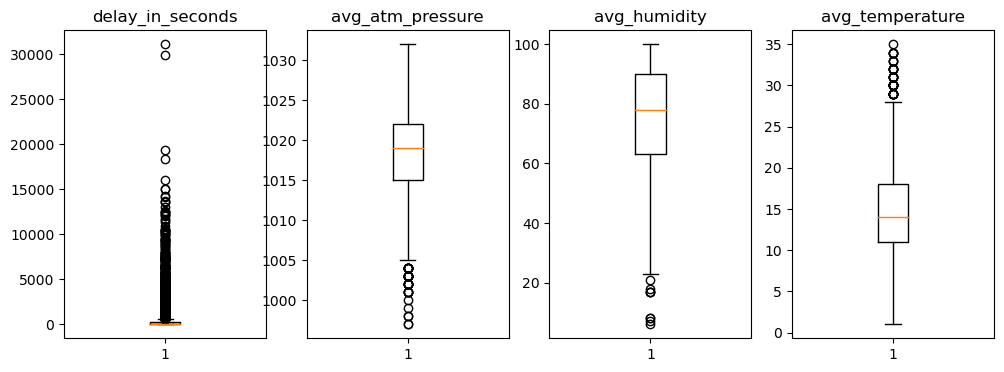

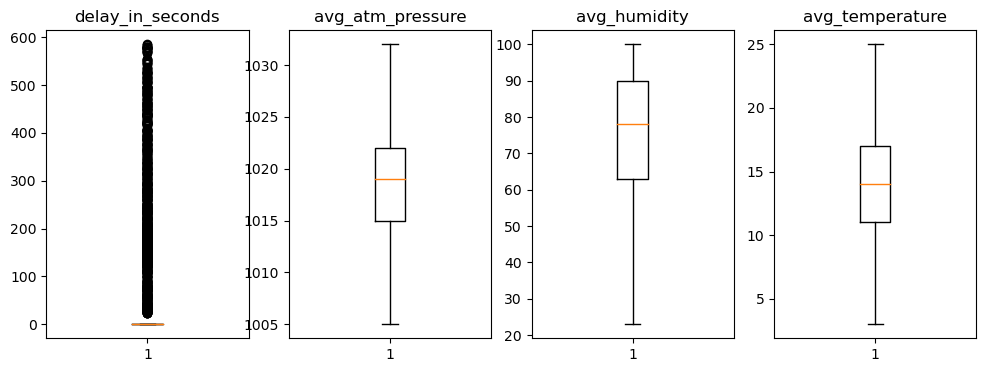

In [80]:
# na fase de exploração, observamos a distribuição de cada feature

# lista de features que apresentem skewness
list_skewned = ['delay_in_seconds', 'avg_atm_pressure', 'avg_humidity']
# lista de features sem skewness
list_not_skewed = ['avg_temperature']

incidentes_metodo1 = incidentes.copy()

# deteção com "IQR", substituição com moda
incidentes_metodo1 = process_outliers(incidentes_metodo1,list_skewned,1,"mode")
# deteção com "MAD", substituição com moda
incidentes_metodo1 = process_outliers(incidentes_metodo1,list_not_skewed,2,"mode")

# Antes do tratamento
plot_boxplots(incidentes,list_skewned+list_not_skewed)

# Após tratamento
plot_boxplots(incidentes_metodo1,list_skewned+list_not_skewed)

### Método 2 - Substituir pela mediana

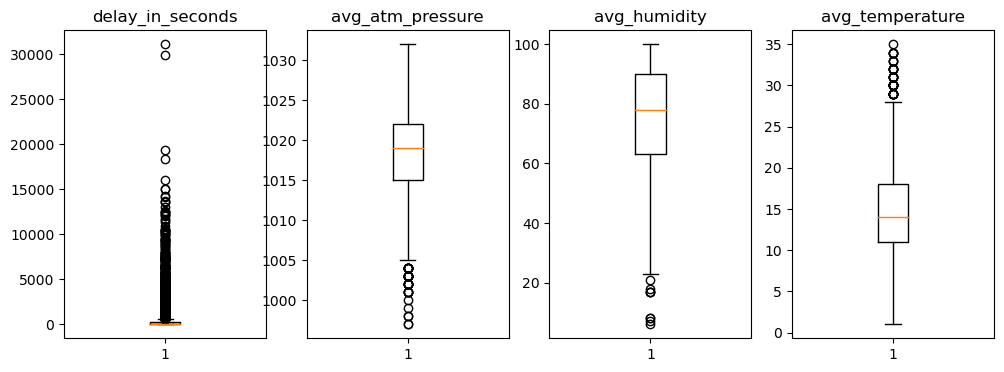

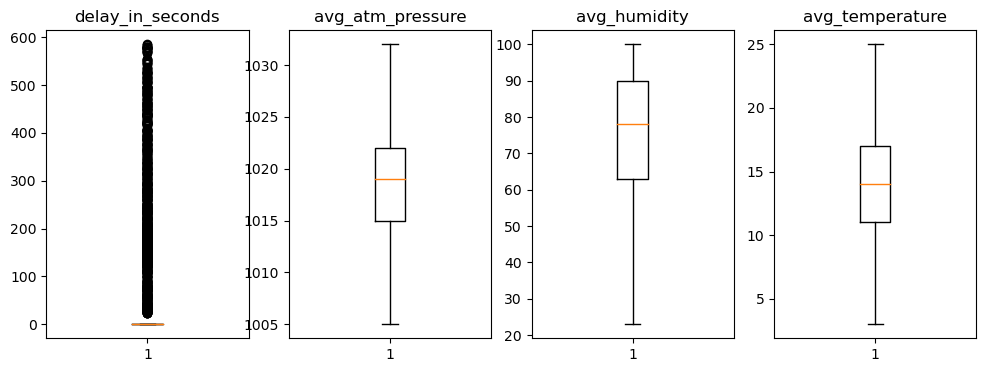

In [81]:
incidentes_metodo2 = incidentes.copy()

# deteção com "IQR", substituição com mediana
incidentes_metodo2 = process_outliers(incidentes_metodo2,list_skewned,1,"median")
# deteção com "MAD", substituição com mediana
incidentes_metodo2 = process_outliers(incidentes_metodo2,list_not_skewed,2,"median")

# Antes do tratamento
plot_boxplots(incidentes,list_skewned+list_not_skewed)

# Após tratamento
plot_boxplots(incidentes_metodo2,list_skewned+list_not_skewed)

### Método 3 - Substituir pela media

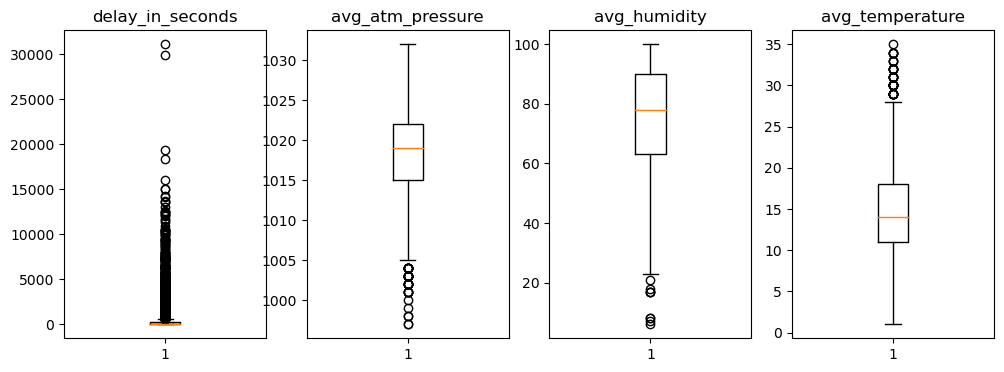

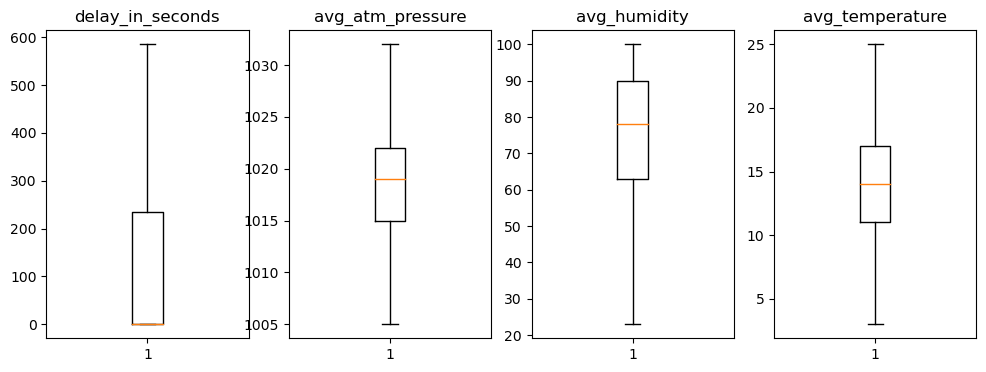

In [82]:
incidentes_metodo3 = incidentes.copy()

# deteção com "IQR", substituição com média
incidentes_metodo3 = process_outliers(incidentes_metodo3,list_skewned,1,"mean")
# deteção com "MAD", substituição com média
incidentes_metodo3 = process_outliers(incidentes_metodo3,list_not_skewed,2,"mean")

# Antes do tratamento
plot_boxplots(incidentes,list_skewned+list_not_skewed)

# Após tratamento
plot_boxplots(incidentes_metodo3,list_skewned+list_not_skewed)

### Método 4 - Remover

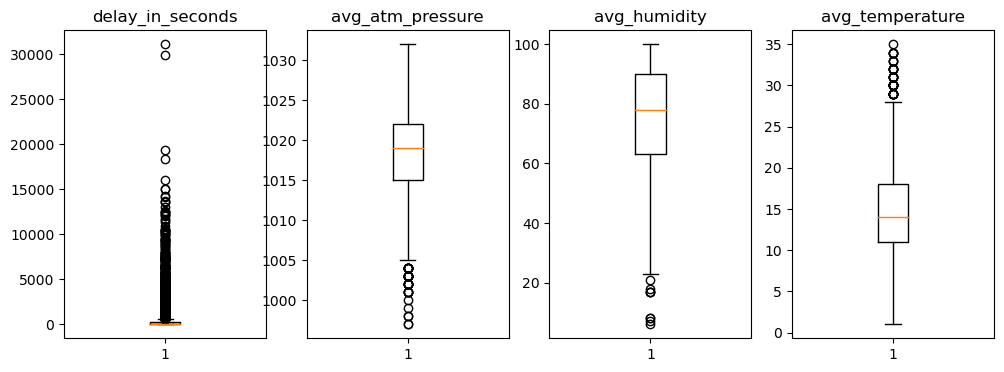

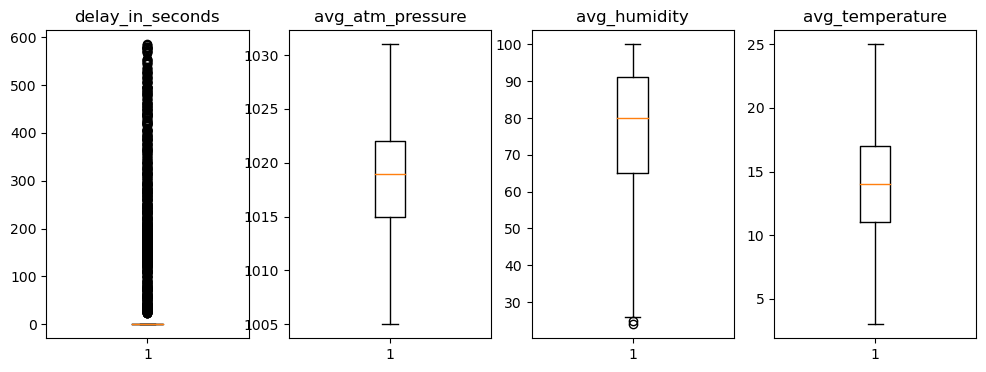

In [83]:
incidentes_metodo4 = incidentes.copy()

# deteção com "IQR", remoção
incidentes_metodo4 = process_outliers(incidentes_metodo4,list_skewned,1,"remove")
# deteção com "MAD", remoção
incidentes_metodo4 = process_outliers(incidentes_metodo4,list_not_skewed,2,"remove")

# Antes do tratamento
plot_boxplots(incidentes,list_skewned+list_not_skewed)

# Após tratamento
plot_boxplots(incidentes_metodo4,list_skewned+list_not_skewed)

## Modelos

In [84]:
#divisão do target
x_moda = incidentes_metodo1.drop(['incidents'], axis=1)
y_moda = incidentes_metodo1['incidents']
#divisão do target
x_media = incidentes_metodo2.drop(['incidents'], axis=1)
y_media = incidentes_metodo2['incidents']
#divisão do target
x_mediana = incidentes_metodo3.drop(['incidents'], axis=1)
y_mediana = incidentes_metodo3['incidents']
#divisão do target
x_remocao = incidentes_metodo4.drop(['incidents'], axis=1)
y_remocao = incidentes_metodo4['incidents']

In [85]:
# função que constrói os modelos, apresentando as métricas
def train_and_predict(X, y, teste):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    models = [RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42),
             LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42),
             GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=42),
             DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=20, random_state=42),
             ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=42),
             KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')]
             
    reports=[]
    acc = []
    pred = []
    names = ['RF','LGB','GB','DT','ET','KN']
    
    for i, model in enumerate(models):
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred)
        reports.append(report)
        accuracy = accuracy_score(y_test, y_pred)
        acc.append(accuracy)
        test_predictions = model.predict(teste)
        pred.append(test_predictions)

    i = 0   
    #Print the reports side by side
    for i, report in enumerate(reports):
        print("Model {} {}:\n{}".format(i + 1, names[i], report))
        print("Accuracy: {:.5f}".format(acc[i]))
        print("=" * 50)
    return pred

In [86]:
incidentes.head()

,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,National,Regional,day_of_month,week_day,month,hour,day_of_year,season,is_holiday,is_weekend
0,0,0,0,12.0,1013.0,70.0,1.0,0,0,0,0,15,0,3,23,74,0,0,1
1,0,385,0,12.0,1007.0,91.0,1.0,0,0,1,0,25,5,12,18,359,3,1,1
2,0,69,2,14.0,1025.0,64.0,0.0,0,1,0,0,12,4,3,15,71,0,0,1
3,2,2297,2,15.0,1028.0,75.0,1.0,0,4,10,1,29,2,9,9,272,3,0,1
4,0,0,2,27.0,1020.0,52.0,1.0,0,3,5,0,13,6,6,11,164,1,0,1


In [87]:
train_and_predict(x_moda,y_moda,teste)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc892fc3d30>
Traceback (most recent call last):
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes call

Model 1 RF:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       517
           1       0.90      0.88      0.89       189
           2       0.85      0.80      0.82       144
           3       0.91      0.84      0.87       265
           4       0.81      0.93      0.87       135

    accuracy                           0.91      1250
   macro avg       0.89      0.89      0.89      1250
weighted avg       0.91      0.91      0.91      1250

Accuracy: 0.91440
Model 2 LGB:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       517
           1       0.89      0.90      0.90       189
           2       0.83      0.77      0.80       144
           3       0.90      0.88      0.89       265
           4       0.86      0.90      0.88       135

    accuracy                           0.92      1250
   macro avg       0.89      0.89      0.89      1250
weighted avg       0.92      0.92 

[array([4, 0, 0, ..., 1, 1, 3]),
 array([4, 0, 0, ..., 3, 1, 3]),
 array([4, 0, 0, ..., 2, 1, 3]),
 array([4, 0, 0, ..., 2, 1, 3]),
 array([4, 0, 0, ..., 1, 1, 3]),
 array([3, 0, 0, ..., 2, 3, 3])]

In [88]:
train_and_predict(x_media,y_media,teste)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc8612f0ca0>
Traceback (most recent call last):
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes call

Model 1 RF:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       517
           1       0.90      0.89      0.90       189
           2       0.86      0.80      0.83       144
           3       0.91      0.84      0.87       265
           4       0.81      0.92      0.86       135

    accuracy                           0.92      1250
   macro avg       0.89      0.89      0.89      1250
weighted avg       0.92      0.92      0.91      1250

Accuracy: 0.91520
Model 2 LGB:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       517
           1       0.89      0.90      0.90       189
           2       0.84      0.78      0.81       144
           3       0.90      0.88      0.89       265
           4       0.86      0.90      0.88       135

    accuracy                           0.92      1250
   macro avg       0.89      0.89      0.89      1250
weighted avg       0.92      0.92 

[array([4, 0, 0, ..., 1, 1, 3]),
 array([4, 0, 0, ..., 2, 1, 3]),
 array([4, 0, 0, ..., 2, 1, 3]),
 array([4, 0, 0, ..., 2, 1, 3]),
 array([4, 0, 0, ..., 0, 1, 3]),
 array([3, 0, 0, ..., 2, 3, 3])]

In [89]:
train_and_predict(x_mediana,y_mediana,teste)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc892fc3b80>
Traceback (most recent call last):
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes call

Model 1 RF:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       517
           1       0.87      0.90      0.89       189
           2       0.86      0.78      0.82       144
           3       0.90      0.86      0.88       265
           4       0.83      0.93      0.87       135

    accuracy                           0.92      1250
   macro avg       0.89      0.89      0.89      1250
weighted avg       0.92      0.92      0.92      1250

Accuracy: 0.91920
Model 2 LGB:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       517
           1       0.88      0.92      0.90       189
           2       0.86      0.77      0.81       144
           3       0.91      0.87      0.89       265
           4       0.83      0.92      0.87       135

    accuracy                           0.92      1250
   macro avg       0.89      0.89      0.89      1250
weighted avg       0.92      0.92 

[array([4, 0, 0, ..., 3, 1, 3]),
 array([4, 0, 0, ..., 3, 1, 3]),
 array([4, 0, 0, ..., 3, 1, 3]),
 array([4, 0, 0, ..., 3, 1, 3]),
 array([4, 0, 0, ..., 4, 1, 3]),
 array([3, 0, 0, ..., 2, 3, 3])]

In [90]:
train_and_predict(x_remocao,y_remocao,teste)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc892fc3b80>
Traceback (most recent call last):
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes call

Model 1 RF:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       512
           1       0.89      0.97      0.93       156
           2       0.94      0.91      0.92       106
           3       0.97      0.96      0.97       191
           4       0.96      0.89      0.93        28

    accuracy                           0.97       993
   macro avg       0.95      0.94      0.95       993
weighted avg       0.97      0.97      0.97       993

Accuracy: 0.96777
Model 2 LGB:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       512
           1       0.89      0.97      0.93       156
           2       0.96      0.91      0.93       106
           3       0.97      0.97      0.97       191
           4       1.00      0.86      0.92        28

    accuracy                           0.97       993
   macro avg       0.96      0.94      0.95       993
weighted avg       0.97      0.97 

[array([4, 0, 0, ..., 1, 1, 3]),
 array([4, 0, 0, ..., 1, 1, 3]),
 array([4, 0, 0, ..., 1, 1, 3]),
 array([4, 0, 0, ..., 1, 1, 3]),
 array([4, 0, 0, ..., 1, 1, 3]),
 array([3, 0, 0, ..., 1, 3, 3])]

### Comparação

Itálico - melhor método de substituição

Negrito e Itálico - melhor valor de entre os modelos

| **Modelo**                          | **Antes** | **Depois (moda)** | **Depois (mediana)** | **Depois (media)** | **Depois (removido)** |
|-------------------------------------|-----------|-------------------|----------------------|--------------------|-----------------------|
| **K Neighbors Classifier**          | 0.83360   | 0.76400           | 0.82320              | 0.76480            | 0.89124               |
| **Extra Trees Classifier**          | 0.90640   | 0.90400           | 0.91040              | 0.89600            | 0.94864               |
| **Gradient Boosting Classifier**    | 0.90960   | 0.89760           | 0.90400              | 0.90000            | 0.95670               |
| **Decision Tree Classifier**        | 0.92240   | 0.89680           | 0.91280              | 0.89760            | **_0.96274_**         |
| **Random Forest Classifier**        | 0.92960   | 0.91440           | 0.91920              | 0.91520            | **_0.96777_**         |
| **Light Gradient Boosting Machine** | 0.93760   | 0.91920           | 0.92320              | 0.92080            | **_0.96979_**         |

Para o próximo cenário de outliers, trataremos as colunas com desvios, com uma transformação logarítmica, é uma das formas possíveis para tratar outliers.
Observe-se o notebook 3.1